We look at Peschel-Emery line for spin half and greater models. The Hamiltonians is 

$$ H = \sum_{j} H_{j,j+1} $$


with 

$$ H^{PE}_{j,j+1}(l) = -\sigma^x_{j}\sigma^x_{j+1} 
+ \frac{h(l)}{2}(\sigma_j^z + \sigma_{j+1}^z) 
+ U(l)\sigma^z_{h}\sigma^z_{j+1}
+ (U(l) + 1)$$

where
$$ U(l) = \frac{1}{2}\left[ \cosh(l)-1\right] $$
and
$$ h(l) = \sinh(l)$$

(0.002502084027901752, 0.10016675001984403)


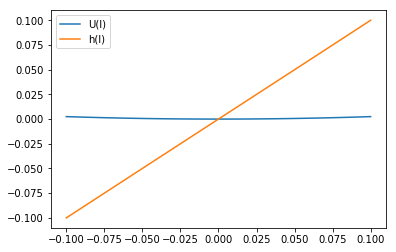

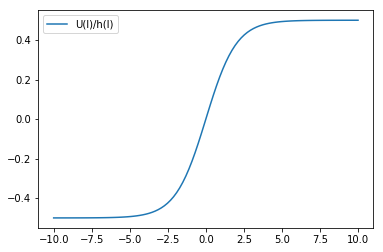

In [24]:
U = lambda x: 0.5*np.cosh(x) - 0.5
h = lambda x: np.sinh(x)

x = np.linspace(-0.1, 0.1, 100)
plt.plot(x, np.vectorize(U)(x), label='U(l)')
plt.plot(x, np.vectorize(h)(x), label='h(l)')
plt.legend()
# plt.yscale('log')

plt.figure()
x = np.linspace(-10, 10, 100)
plt.plot(x, np.vectorize(U)(x)/np.vectorize(h)(x), label='U(l)/h(l)')
plt.legend()
print((U(0.1), h(0.1)))

For open boundary conditions this can be modelled using an MPO like

$$H_i(L) = \left(
\begin{array}{ccc}
I_i & \sigma_i^x & \sigma_i^z & \frac{c(i)}{2}\left(h(l)\sigma^z_i + U(l) + 1\right)\\
0   &     0      &     0      & -\sigma_i^x\\
0   &     0      &     0      & U(l)\sigma_i^z \\
0   &     0      &     0      &  I
\end{array}
\right)$$

Where $c(i) = 2 \forall i s.t. 1 < i < N$ otherwise $c(i) = 1$

MPO construction 

$$ 
\left( 
  \begin{array}{ccc} 
    I & \sigma^x & I \\
    0 & 0 & \sigma^x \\
    0 & 0 & I
  \end{array}
\right)
\left( 
  \begin{array}{ccc} 
    I & \sigma^x & I \\
    0 & 0 & \sigma^x \\
    0 & 0 & I
  \end{array}
\right)
=
\left( 
  \begin{array}{ccc} 
    I \otimes I & I \otimes \sigma^x & I \otimes I + \sigma^x \otimes \sigma^x + I \otimes I \\
    0 & 0 & \sigma^x \otimes I\\
    0 & 0 & I \otimes I
  \end{array}
\right)
$$

$$ 
\left( 
  \begin{array}{ccc} 
    I & \sigma^x & I \\
    0 & 0 & \sigma^x \\
    0 & 0 & I
  \end{array}
\right)
\left( 
  \begin{array}{ccc} 
    I & \sigma^x & I \\
    0 & 0 & \sigma^x \\
    0 & 0 & I
  \end{array}
\right)
\left( 
  \begin{array}{ccc} 
    I & \sigma^x & I \\
    0 & 0 & \sigma^x \\
    0 & 0 & I
  \end{array}
\right)
=
\left( 
  \begin{array}{ccc} 
    I \otimes I \otimes I & I \otimes I \otimes \sigma^x & I \otimes I \otimes I + I \otimes \sigma^x \otimes \sigma^x + I \otimes I \oteims I + 
    + I \otimes \sigma^x \otimes \sigma^x \\
    0 & \sigma^x \otimes \sigma^x \otimes \sigma^x
  \end{array}
\right)
$$

In [1]:
import sympy as sy

N = 3

U = sy.Symbol('U')
h = sy.Symbol('h')
sxs = [sy.Symbol('sx_' + str(x)) for x in range(N)]
szs = [sy.Symbol('sz_' + str(x)) for x in range(N)]
Is = [sy.Symbol('I_' + str(x)) for x in range(N)]

L = sy.Matrix([[1, 0, 0, 0]])
R = sy.Matrix([[0], [0], [0], [1]])

mats = [sy.Matrix([[Is[x], sxs[x], szs[x], szs[x] * h/2 + U + 1], [0, 0, 0, sxs[x]], [0, 0, 0, U*szs[x]], [0, 0, 0, Is[x]]]) for x in range(N)]

A = mats[0]
for i in range(1,len(mats)):
    A = A * mats[i]
    
L*A*R

ModuleNotFoundError: No module named 'sympy'

In [2]:
import numpy as np
print(L.shape)
print(mats[0].shape)
print(R.shape)
R.dot(mats[0])

NameError: name 'L' is not defined

## Create new class to implement model

In [25]:
import time
import numpy as np
import matplotlib.pyplot as plt
%matplotlib

from parafermions.MPO import MPO
import parafermions.ParafermionUtilsCython as pfcy

RuntimeError: Python is not installed as a framework. The Mac OS X backend will not be able to function correctly if Python is not installed as a framework. See the Python documentation for more information on installing Python as a framework on Mac OS X. Please either reinstall Python as a framework, or try one of the other backends. If you are using (Ana)Conda please install python.app and replace the use of 'python' with 'pythonw'. See 'Working with Matplotlib on OSX' in the Matplotlib FAQ for more information.

In [26]:
class PeschelEmerySpinHalf(MPO):
    """
    Class which contains method for treating Peschel Emery line of parameters
    """

    def __init__(self, L, l, dtype=np.dtype('complex128')):
        """
        Constructor of spin half Peschel Emergy chain operator class with the given parameters.

        Parameters
        -----------        
        L: int
            Length of chain.
        l: float
            The sinlge parameter of the Peschel Emery spin half line
        dtype: dtype
            Datatype to use internally, default=np.dtype('complex128').
        """
        self.L = L   # otherwise full hamiltonian        
        self.l = l
        self.N = 2
        
        # setting dimension and datatype
        self.dim = self.N**self.L
        self.dtype = dtype
        self.chi = 4
        
        self.sigmax = np.zeros((2, 2), dtype=self.dtype)
        self.sigmax[0, 1] = 1; self.sigmax[1, 0] = 1
        
        self.sigmaz = np.zeros((2, 2), dtype=self.dtype)
        self.sigmaz[0, 0] = 1; self.sigmaz[1, 1] = -1
        
        self.I = np.eye(2, dtype=self.dtype)
        self.Ul = (np.cosh(self.l) - 1)/2.0
        self.hl = np.sinh(l)
        
        c_i = lambda x: 2 if x > 0 and x < self.L-1 else 1 

        Ws = dict() # create a dictionary to store tensors
        for i in range(self.L):
            W = np.zeros((self.chi,self.chi,self.N,self.N), dtype=self.dtype)                        
            W[0,0:4] = [self.I, self.sigmax, self.sigmaz, c_i(i)/2*(self.hl*self.sigmaz + self.I *(self.Ul + 1))]
            W[1,-1] = -self.sigmax
            W[2,-1] = self.Ul * self.sigmaz
            W[-1,-1] = self.I
            Ws[i] = W
        
        self.shape = (self.N**self.L, self.N**self.L) # for mat vec routine
        self.Lp = np.zeros(self.chi, dtype=dtype); self.Lp[0] = 1.0
        self.Rp = np.zeros(self.chi, dtype=dtype); self.Rp[-1] = 1.0
        self.Ws = Ws

In [27]:
class ParitySpinHalf(MPO):
    """
    Parity operator for spin half chains
    """

    def __init__(self, L, dtype=np.dtype('complex128')):
        """
        Parity operator for spin half chains

        Parameters
        -----------        
        L: int
            Length of chain.        
        dtype: dtype
            Datatype to use internally, default=np.dtype('complex128').
        """
        self.L = L   # otherwise full hamiltonian        
        self.N = 2
        
        # setting dimension and datatype
        self.dim = self.N**self.L
        self.dtype = dtype
        self.chi = 1
        
        self.sigmaz = np.zeros((2, 2), dtype=self.dtype)
        self.sigmaz[0, 0] = 1; self.sigmaz[1, 1] = -1
        
        self.I = np.eye(2, dtype=self.dtype)
                
        Ws = dict() # create a dictionary to store tensors
        for i in range(self.L):
            W = np.zeros((self.chi,self.chi,self.N,self.N), dtype=self.dtype)                        
            W[0,0] = self.sigmaz            
            Ws[i] = W
        
        self.shape = (self.N**self.L, self.N**self.L) # for mat vec routine
        self.Lp = np.zeros(self.chi, dtype=dtype); self.Lp[0] = 1.0
        self.Rp = np.zeros(self.chi, dtype=dtype); self.Rp[-1] = 1.0
        self.Ws = Ws

[1.51596330e-15 2.44136976e-15 1.64063042e+00 1.64063042e+00
 1.69724695e+00 1.69724695e+00 1.78542950e+00 1.78542950e+00
 1.89654719e+00 1.89654719e+00]
Energy expectations: [-7.473396209299503e-16, -7.65283392685311e-16]
Parity expectations: [-0.9999782657177949, 0.9999782657177898]


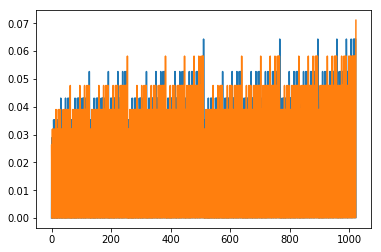

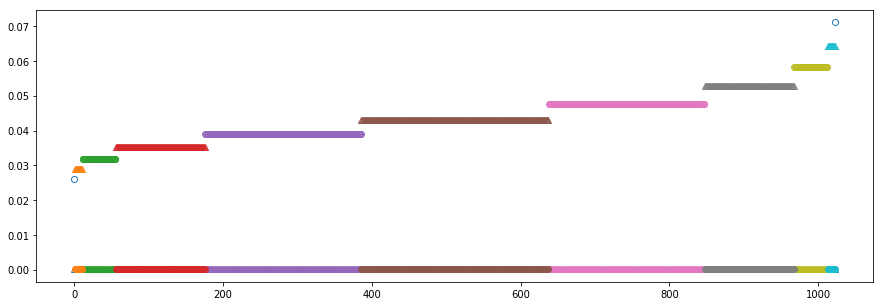

In [38]:
import parafermions as pf
import numpy as np

N = 10
l = 0.2
pe = PeschelEmerySpinHalf(N, l, dtype=np.dtype('float64'))
d, v = pe.Diagonalise(k=100)
print(d[:10])
P = ParitySpinHalf(N, dtype=np.dtype('float64'))

w = pf.diagonalise(v[:,:2], P)
w.shape

print('Energy expectations: ' + str([pe.expectation(w[:, x]) for x in range(w.shape[1])]))
print('Parity expectations: ' + str([P.expectation(w[:, x]) for x in range(w.shape[1])]))

plt.plot(w)

def str_conf(idx, N):
    x = np.base_repr(idx)    
    return '0'*(N-len(x)) + x

def up_count(idx):
    return len([x for x in np.base_repr(idx) if x == '1'])

import seaborn as sns
colors = sns.color_palette(n_colors=N+1)


plt.figure(figsize=(15,5))
i = 0
sorted_tuples = sorted([[up_count(x), w[x, i]] for x in range(w.shape[0])], key=lambda x: x[0])
for j, t in enumerate(sorted_tuples):
    plt.plot(j, t[1], '^', color=colors[t[0]], fillstyle='none')
    
i = 1
sorted_tuples = sorted([[up_count(x), w[x, i]] for x in range(w.shape[0])], key=lambda x: x[0])
for j, t in enumerate(sorted_tuples):
    plt.plot(j, t[1], 'o', color=colors[t[0]], fillstyle='none')

In [29]:
np.exp(-0.05)

0.951229424500714

# Attempt the three state potts typed model

In [33]:
class PeschelEmery3StateClock(MPO):
    """
    Class which contains method for treating Peschel Emery line of parameters
    """

    def __init__(self, L, r, dtype=np.dtype('complex128')):
        """
        Constructor of spin half Peschel Emergy chain operator class with the given parameters.

        Parameters
        -----------        
        L: int
            Length of chain.
        r: float
            The sinlge parameter of the Peschel Emery spin half line
        dtype: dtype
            Datatype to use internally, default=np.dtype('complex128').
        """
        self.L = L   # otherwise full hamiltonian        
        self.r = r
        self.N = 3
        
        # setting dimension and datatype
        self.dim = self.N**self.L
        self.dtype = dtype
        self.chi = 8
        self.omega = np.exp(2j*np.pi/3)
        
        self.sigmax = np.zeros((3, 3), dtype=self.dtype)
        self.sigmax[0, 1] = 1; self.sigmax[1, 2] = 1; self.sigmax[2, 0] = 1
        
        self.sigmaz = np.diag([self.omega**x for x in range(3)])
        
        self.I = np.eye(3, dtype=self.dtype)
        self.fr = (1+2*r)*(1-r**3)/(9*r**2)
        self.g1r = -2*(1-r)**2*(1+r+r**2)/(9*r**2)
        self.g2r = (1-r)**2*(1-2*r-2*r**2)/(9*r**2)
        self.er = 2*(1+r+r**2)**2/(9*r**2)
        
        c = lambda x: 2 if x > 0 and x < self.L-1 else 1 

        Ws = dict() # create a dictionary to store tensors
        for i in range(self.L):
    
            W = np.zeros((self.chi,self.chi,self.N,self.N), dtype=self.dtype)                        
            W[0,0:3] = [self.I, self.sigmax.conj().T, self.sigmax]
            W[0,3:5] = [self.sigmaz, self.sigmaz.conj().T]
            W[0,5:7] = [self.sigmaz, self.sigmaz.conj().T]
            W[0,7] = c(i)*(-self.fr*(self.sigmaz + self.sigmaz.conj().T) + self.er*self.I/2)
            W[1,-1] = -self.sigmax; W[2,-1] = -self.sigmax.conj().T
            W[3, -1] = -self.g1r*self.sigmaz
            W[4, -1] = -self.g1r*self.sigmaz.conj().T
            W[5, -1] = -self.g2r*self.sigmaz.conj().T
            W[6, -1] = -self.g2r*self.sigmaz            
            W[-1,-1] = self.I
            Ws[i] = W
        
        self.shape = (self.N**self.L, self.N**self.L) # for mat vec routine
        self.Lp = np.zeros(self.chi, dtype=dtype); self.Lp[0] = 1.0
        self.Rp = np.zeros(self.chi, dtype=dtype); self.Rp[-1] = 1.0
        self.Ws = Ws

In [34]:
pe3 = PeschelEmery3StateClock(8, 1)
p, v = pe3.Diagonalise(k=20)
[np.abs(x) for x in p]

[9.74380295219632e-16,
 7.963106170112706e-16,
 7.719343683239686e-16,
 2.9999999999999964,
 2.999999999999999,
 3.0000000000000075,
 3.000000000000011,
 3.000000000000013,
 3.0000000000000213,
 3.0000000000000218,
 3.00000000000003,
 3.0000000000000373,
 3.0000000000000404,
 3.000000000000041,
 5.999999999999996,
 6.000000000000022,
 6.000000000000041,
 6.000000000000049,
 6.000000000000051,
 6.000000000000057]

In [12]:
P = pf.QOp(3, 8)
w = pf.diagonalise(v[:, :3], P)

In [13]:
[P.expectation(w[:, i].conj()) for i in range(w.shape[1])]

[(1.000000000000061+5.88418203051333e-15j),
 (-0.5000000000000218+0.8660254037844674j),
 (-0.5000000000000073-0.8660254037844577j)]

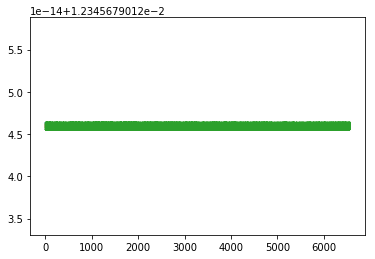

In [14]:
plt.plot(np.abs(w))

In [328]:
np.dot(w[:,0].conj(), w[:,0])

(1.0000000000000044+0j)